# Fragmentation Graph Vignette

This notebook show a simple use case of the fragmentation graph algorithm. 
To illustrate the capacity of the method a sample of unmodified H3 n-terminal tail is analyzed here 


### Setting Up Environment

#### Using a Predefined Conda Environment

If you have launched this Jupyter notebook using the provided script (setup_notebook.sh), you should already have the fraggraphenv conda environment available. To use this environment within the Jupyter notebook:

Selecting the Kernel:
<ul>
<li>Go to the top menu in Jupyter Notebook.</li>
<li>Click on Kernel.</li>
<li>From the dropdown menu, select Change kernel.</li>
<li>Choose Python (fraggraphenv) from the list. This action will switch the notebook to use the fraggraphenv environment.</li>
</ul>


#### Setting Up Dependencies Manually

In case you did not use the provided script, or if you are working in a different setup, you can install the dependencies directly via pip (uncomment and run the line below)

In [20]:
#import os
#os.system("pip install -r requirements.txt")

## Spectra Merging

The fragmentation graph takes a peak list as an input (mz values, intensity values).

Here spectra are merged as one peaklist using the "combine_spectra" module. 
Merging spectra helps improving the signal to noise ratio. 



In [1]:
from fraggraph.combine_spectra import combine_spectra

SPECTRA_FILE = "data/H3_tail_unmod/25unmod_Agc1e5Z10ETD40SA20Uscan3INJT150Res30000.mzML"

#merge spectra in a  single consensus spectrum
consensus_spectra = combine_spectra(SPECTRA_FILE, mzd=0.01)
print("Number of peaks in consensus spectrum: ", len(consensus_spectra))

#filter out peaks that are found in less than 10% of the spectra
consensus_spectra = consensus_spectra[consensus_spectra["cov_spectra"] >= 0.1]
consensus_spectra = consensus_spectra.reset_index(drop=True)
print("Number of peaks in consensus spectrum after filtering: ", len(consensus_spectra))

Number of peaks in consensus spectrum:  1066
Number of peaks in consensus spectrum after filtering:  1066


## Fragmentation graph 


The FragGraph Class is used to represent the set of theoretical fragment as a graph and their annotation to the experimental spectrum

When instanciating the class, the parameters for the fragment generation must be defined (e.g types of fragments, tolerances, deconvolution applied etc...)
Parameters for the most common fragmentation are defined in "fragmentation_parameters.json", in this example we will use the "ETD" parameters. 
(additionally, specific paramters value can be passed directly to the constructor)

Once instantiated the graph can be generated with the generate_graph() method. The following paramters are required:
<ul>
<li>peptidoforms: List of peptide forms from which theoretical fragment are generated.</li>
<li>mz_list: List of mass-to-charge ratios (m/z) of the experimental spectrum.</li>
<li>intensities_list: List of intensity values of the experimental spectrum.</li>
</ul>

Main processing Steps (non-exhaustive):
<ol>
<li>Converts peptidoforms to psm_utils.Peptidoform objects.</li>
<li>Determines maximum charge for precursor peptides (if not specified manually in framgentation_parameters)</li>
<li>Estimates the maximum number of isotopic peaks to consider based on maximum fragment mass and the ratio between maximum and minimum peak intensities.</li>
<li>Adds spectrum peaks to the graph.</li>
<li>Creates root nodes for precursors, generated nodes representing all possible fragments and matches them to the experimental peaks nodes.</li>
<li>Computes cosine similarity between theoretical and experimental isotopic pattern.</li>
<li>Filters nodes based on cosine similarity threshold.</li>
<li>Propagates intensity through the graph and removes branches whith no annotated fragments.</li>
</ol>

The resulting object is a directed graph encapsulating:
Nodes representing various fragment types, charge states, and isotopes.
Nodes representing the experimental spectrum.
Edges denoting relationships between these fragments.

In [2]:
from fraggraph.frag_graph_fast import FragGraph

PEPTIDOFORM = "ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALRE"

#instanciate a FragGraph object (here the fragmentation parameters can be specified)
FG = FragGraph(fragmentation_parameters="ETD")

#generate the fragmentation graph by passing the peptidoform and the consensus spectrum's m/z and intensity values
FG.generate_graph([PEPTIDOFORM], consensus_spectra["mz_mean"], consensus_spectra["its_mean"])



max isotope:  8


Adding Nodes: 100%|███████████████████████████████████████████████████████████████| 1127/1127 [00:07<00:00, 146.77it/s]


##############
number of each node type:
Counter({'intermediate_2': 33570, 'peak': 4694, 'leaf': 3843, 'intermediate_1': 3369, 'intermediate_0': 1127, 'peak_viz': 1066, 'root': 1})
##############
##############
number of each node type:
Counter({'intermediate_1': 3369, 'peak': 2233, 'leaf': 2091, 'intermediate_0': 1127, 'peak_viz': 997, 'intermediate_2': 738, 'root': 1})
##############
##############
number of each node type:
Counter({'intermediate_1': 3369, 'peak': 2233, 'leaf': 2091, 'intermediate_0': 1127, 'peak_viz': 997, 'intermediate_2': 738, 'root': 1})
##############


100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [00:00<00:00, 1248.74it/s]


490  nodes have been removed based on best isotopic fit


## Visualize fragmentation graph 



In [3]:
import os
from fraggraph.frag_graph_viz import draw_graph3 as draw_graph

draw_graph(FG, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD.html"))

[Open Generated HTML File](./jupyter_output/graph_H3tail_ETD.html)


## Visualize annotation  

Additional visualization functions are available in "source/frag_graph_report"


The experimental spectrum can be plotted as such

In [4]:
import os
os.environ["R_HOME"] = "C:\\Users\\P42587\\AppData\\Local\\Programs\\R\\R-4.3.2"
from fraggraph.frag_graph_report import plot_spectrum as plot_mass_spectrum

In [5]:
### DOESNT EXIST
"""
from importlib import reload
import source.frag_graph_report
reload(source.frag_graph_report)
from source.frag_graph_report import *

plot_mass_spectrum(FG, color_map={"terminal": "black", "internal": "black","unassigned": "black", "both": "black"})

plot_mass_spectrum(FG, color_map={"terminal": "red", "internal": "white","unassigned": "white", "both": "white"})

plot_mass_spectrum(FG,filename=os.path.join("jupyter_output", f"mass_spectrum_H3tail_ETD_all no sdi.svg"))
"""

'\nfrom importlib import reload\nimport source.frag_graph_report\nreload(source.frag_graph_report)\nfrom source.frag_graph_report import *\n\nplot_mass_spectrum(FG, color_map={"terminal": "black", "internal": "black","unassigned": "black", "both": "black"})\n\nplot_mass_spectrum(FG, color_map={"terminal": "red", "internal": "white","unassigned": "white", "both": "white"})\n\nplot_mass_spectrum(FG,filename=os.path.join("jupyter_output", f"mass_spectrum_H3tail_ETD_all no sdi.svg"))\n'

C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2422: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


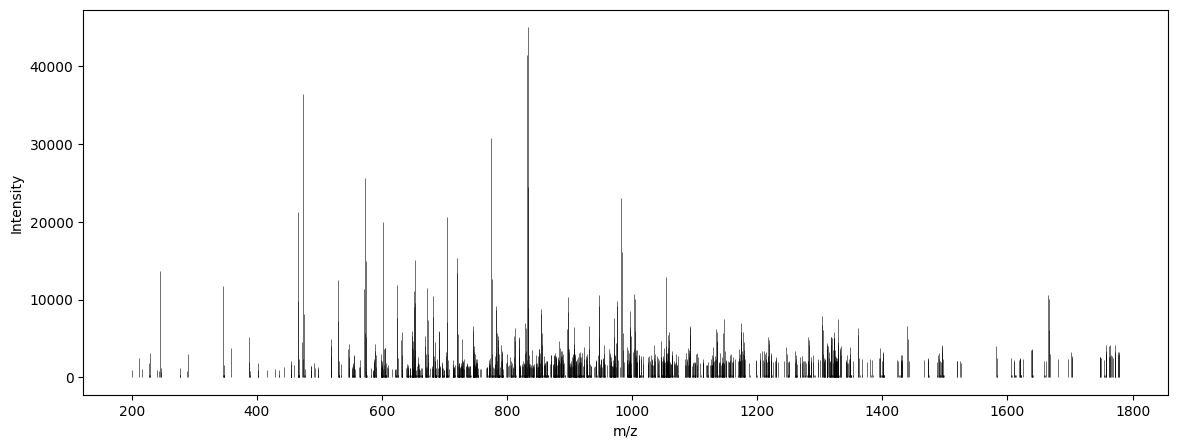

<module 'matplotlib.pyplot' from 'C:\\Users\\P42587\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\pyplot.py'>

In [6]:


plot_mass_spectrum(FG)


Plot the distribution of intensities

In [7]:
### DOESNT EXIST
"""
from importlib import reload
import source.frag_graph_report
reload(source.frag_graph_report)
from source.frag_graph_report import *
plot_intensity_distribution(FG, filename=os.path.join("jupyter_output", f"intensity_distribution_H3tail_ETD.svg"))
"""

'\nfrom importlib import reload\nimport source.frag_graph_report\nreload(source.frag_graph_report)\nfrom source.frag_graph_report import *\nplot_intensity_distribution(FG, filename=os.path.join("jupyter_output", f"intensity_distribution_H3tail_ETD.svg"))\n'

C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\P42587\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\P42587\AppData\Roaming\Python\Python311\site-packages\plotnine\ggplot.py:605: PlotnineWarning: Filename: jupyter_output\intensity_distribution_H3tail_ETD.svg


total intensity:  3174049.5332428636


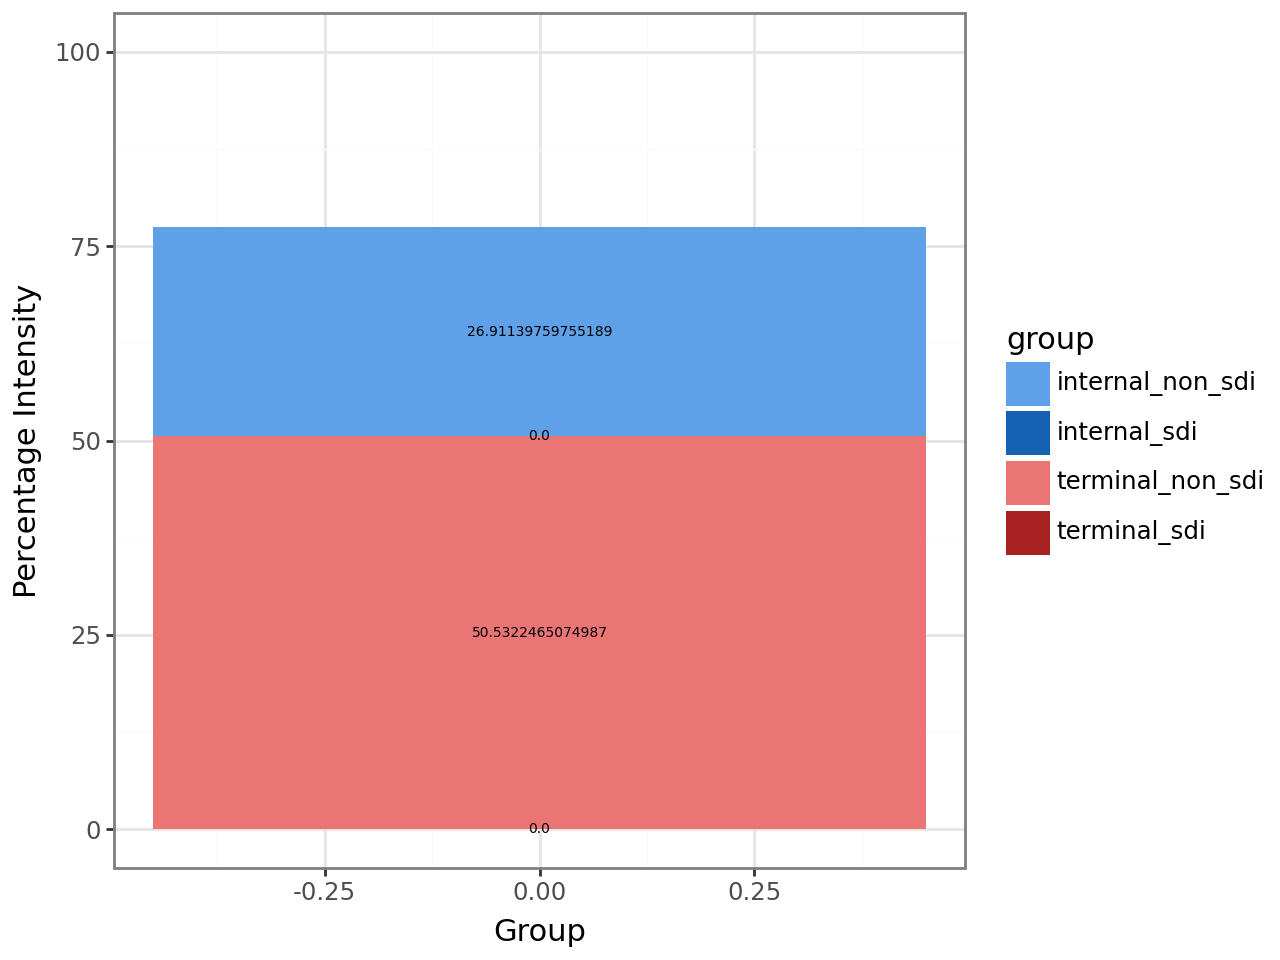

In [8]:
from fraggraph.frag_graph_report import percentage_intensity_distribution
percentage_intensity_distribution(FG, filename=os.path.join("jupyter_output", f"intensity_distribution_H3tail_ETD.svg"))

In [9]:
### DOESNT EXIST
"""
plot_fragment_count_distribution(FG, filename=os.path.join("jupyter_output", f"fragment_count_distribution_H3tail_ETD.svg"))
"""

'\nplot_fragment_count_distribution(FG, filename=os.path.join("jupyter_output", f"fragment_count_distribution_H3tail_ETD.svg"))\n'

Above the summed intensity of each fragment position is represented by the color gradient. 
It is also possible to plot different metrics

Below is plotted the average cosine similarity score. (You can try other metrics, be aware that the range (x_min x_max need to be changed accordingly) )

C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


start_pos -> 1 47
end_pos -> 3 50
frag_codes -> ['t:t@10:17'] ['t:t@9:39']
intensity -> 19.04265843016531 161079.06085941
n_child_I1 -> 1.0 4.0
n_child_I2 -> 1.0 6.0
avg_charge -> 1.0 9.0
avg_cosine_similarity -> 0.7086577102873478 1.0
mz -> 287.63945724235 4964.8839583624


C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


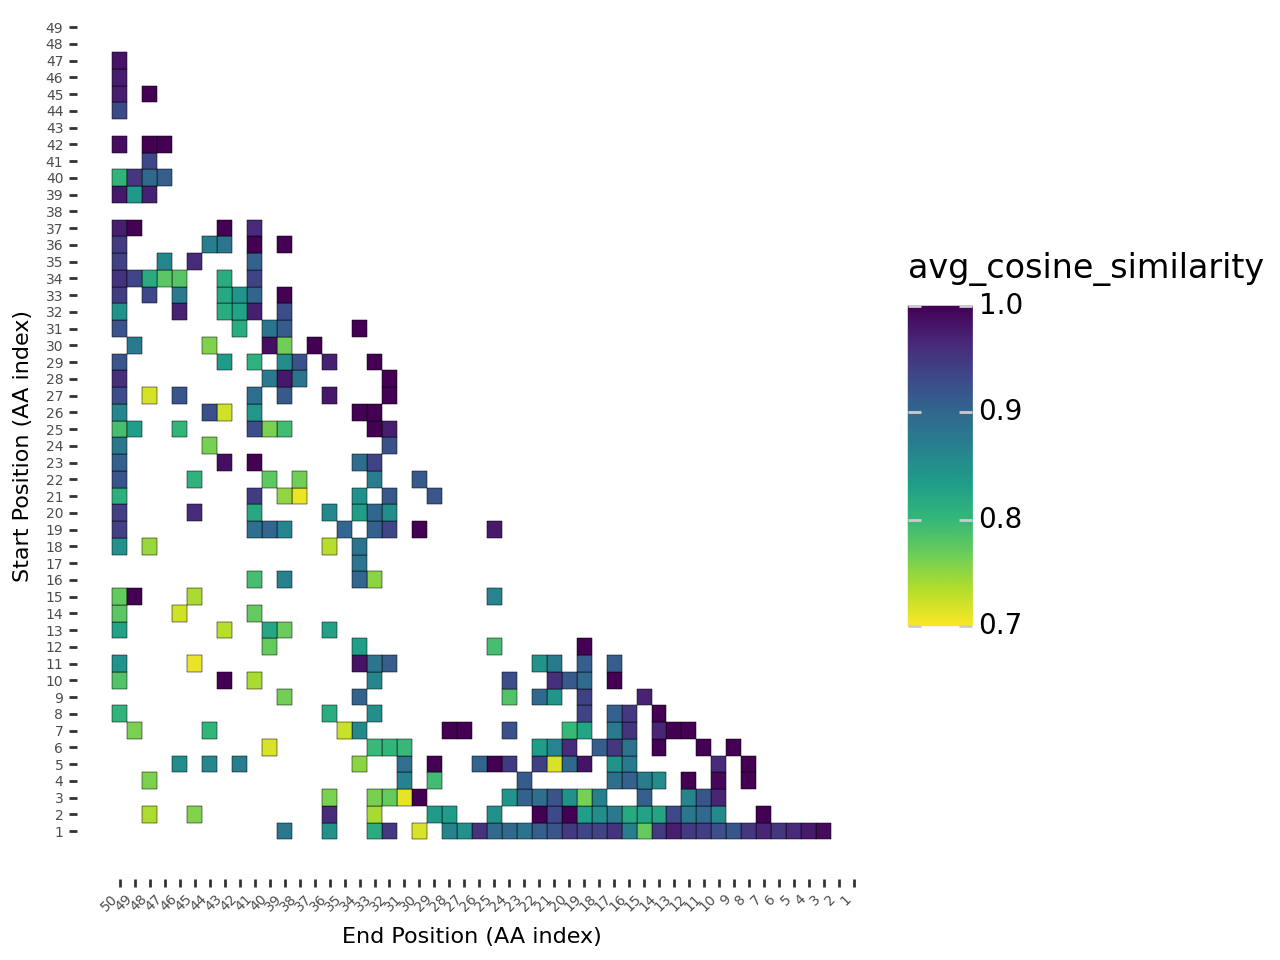

In [10]:
from fraggraph.frag_graph_report import draw_fragment_coverage_matrix

#print the column names of the fragment table used to generate the coverage matrix and the range of the values
frag_table = FG.get_fragment_table_I0()
for col in frag_table.columns:
    print(col, end=" -> ")
    print(frag_table[col].min(), frag_table[col].max())


draw_fragment_coverage_matrix(FG, x="avg_cosine_similarity", x_min=0.7, x_max=1)

Annotation of spectra with internal ions likely leads to overlap between annotation (i.e multiple fragmetns annotated to same experimental peak)
The folowing can be used to view whether fragmetns are overlapping with others

In [11]:
#doesn't work TODO
#draw_fragment_coverage_matrix_binned_mz(FG)

## Use case: comparing two peptidoform annotations

The strengh of this approach resides in its capacity to annotate two peptidoforms simultaneously. 
Using the same spectra we will annotate the original sequence and a sequence where a mass shift was induced between amino acids

In [12]:
#define a second proteoform with mass shift (here a phosphorylation)

pos_1 = 32
pos_2 = 35
mass_shift = "79.966331"

PEPTIDOFORM_SHIFT = (
    PEPTIDOFORM[:pos_1]
    + f"[-{mass_shift}]"
    + PEPTIDOFORM[pos_1:pos_2]
    + f"[+{mass_shift}]"
    + PEPTIDOFORM[pos_2:]
)
print(PEPTIDOFORM_SHIFT)

FG_dual = FragGraph(fragmentation_parameters="ETD")


FG_dual.generate_graph(
    [PEPTIDOFORM, PEPTIDOFORM_SHIFT],
    consensus_spectra["mz_mean"],
    consensus_spectra["its_mean"],
)


ARTKQTARKSTGGKAPRKQLATKAARKSAPAT[-79.966331]GGV[+79.966331]KKPHRYRPGTVALRE
max isotope:  8


Adding Nodes:  12%|███████▍                                                        | 132/1127 [00:01<00:08, 114.81it/s]


##############
number of each node type:
Counter({'intermediate_2': 38410, 'peak': 4710, 'leaf': 3858, 'intermediate_1': 3853, 'intermediate_0': 1259, 'peak_viz': 1066, 'root': 2})
##############
##############
number of each node type:
Counter({'intermediate_1': 3853, 'peak': 2242, 'leaf': 2102, 'intermediate_0': 1259, 'peak_viz': 996, 'intermediate_2': 744, 'root': 2})
##############
##############
number of each node type:
Counter({'intermediate_1': 3853, 'peak': 2242, 'leaf': 2102, 'intermediate_0': 1259, 'peak_viz': 996, 'intermediate_2': 744, 'root': 2})
##############


100%|██████████████████████████████████████████████████████████████████████████████| 539/539 [00:00<00:00, 1169.48it/s]


495  nodes have been removed based on best isotopic fit


We can plot fragment coverage matrix for both peptidoforms

C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


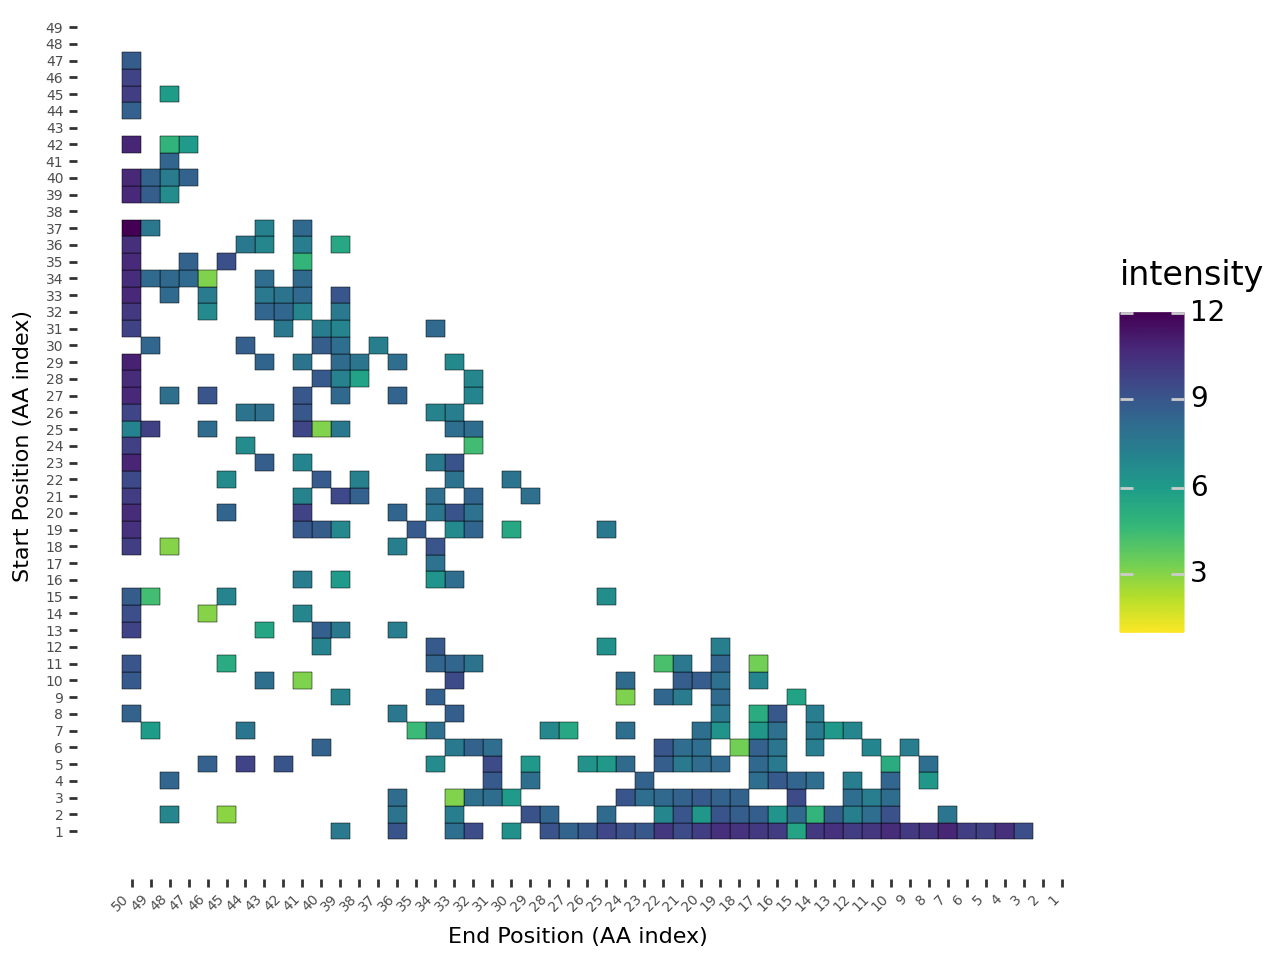

In [13]:
#Original sequence
draw_fragment_coverage_matrix(
    FG_dual,x="intensity", x_min=1, x_max=12, peptidoform_index=0
)

C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


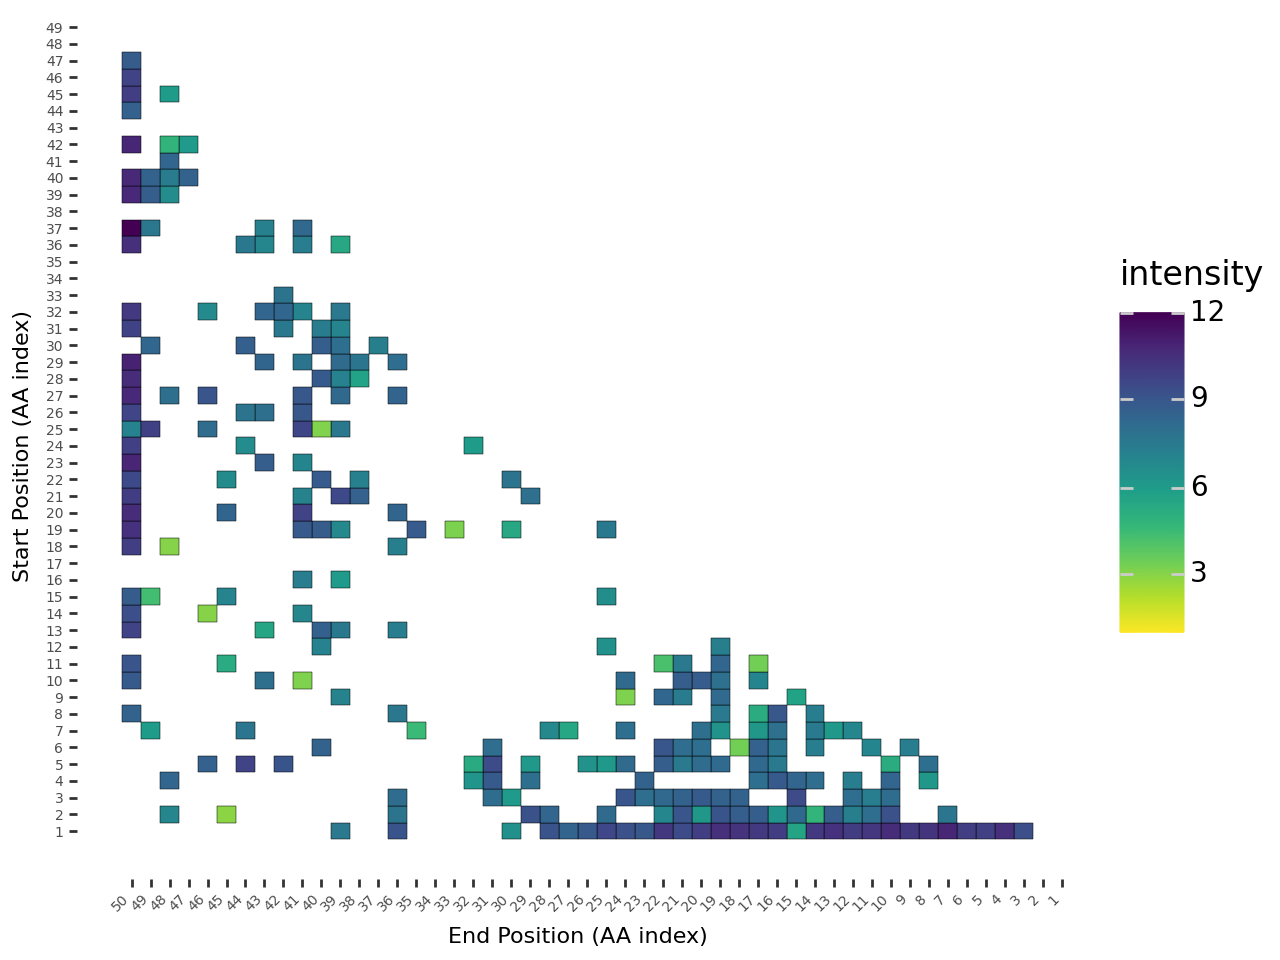

In [14]:
#Original sequence with mass shift 
draw_fragment_coverage_matrix(
    FG_dual,x="intensity", x_min=1, x_max=12, peptidoform_index=1
)

The changes in fragment intensities between the two annotations can be better visualized using "draw_fragment_coverage_matrix_difference"
(Negative values indicate decrease of intensiy in the second proteoform annotation (" FG2_peptidoform_index"), a cross inicates that the fragment is not annotated in the second proteoform)

C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


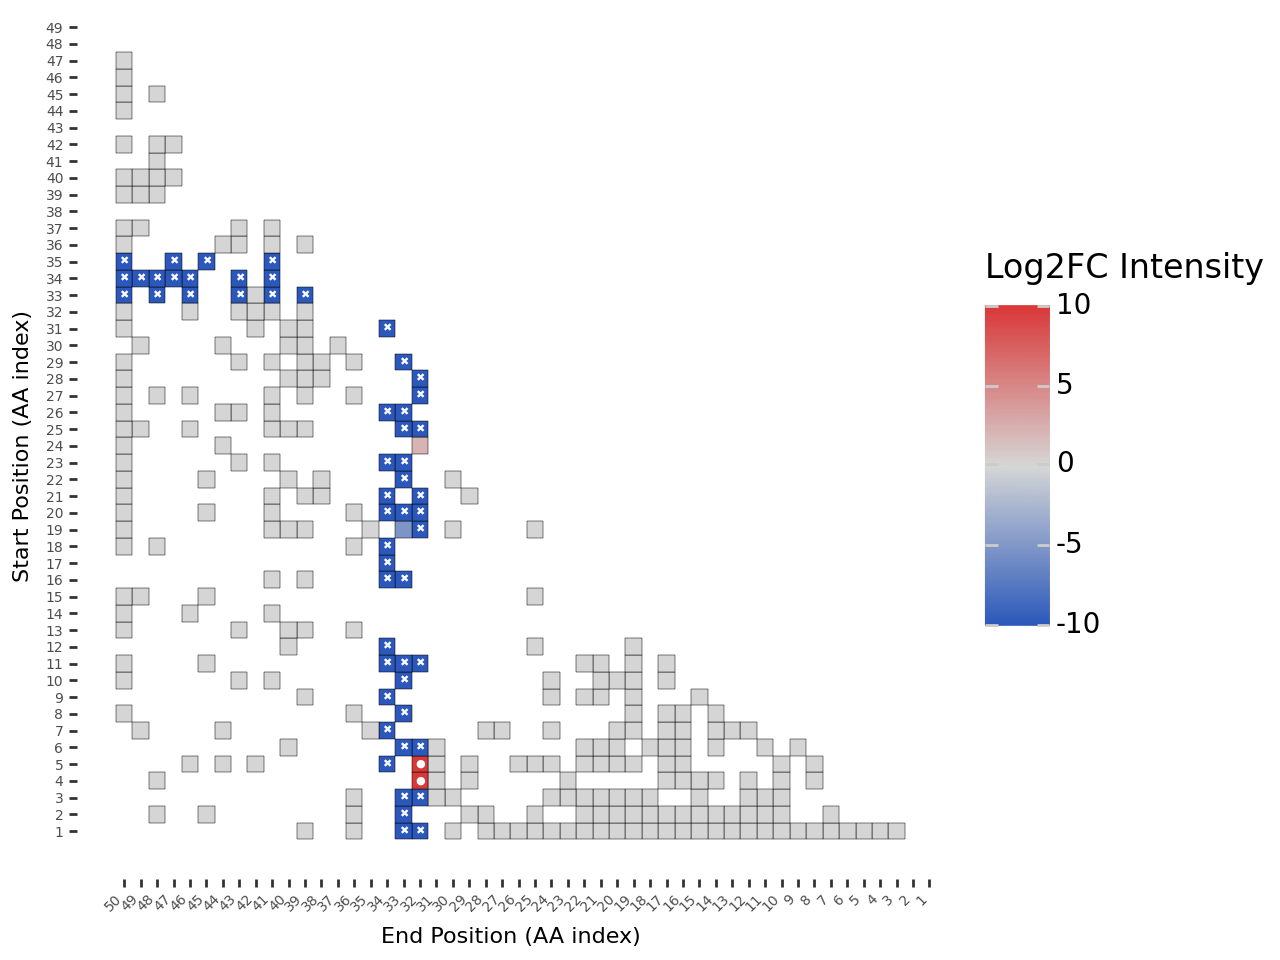

In [15]:
from fraggraph.frag_graph_report import draw_fragment_coverage_matrix_difference


draw_fragment_coverage_matrix_difference(
    FG_dual,
    FG_dual,
    mod1_position=pos_1,
    mod2_position=pos_2,
    FG1_peptidoform_index=0,
    FG2_peptidoform_index=1
)


C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\P42587\Documents\GitHub\internal_ions\fraggraph\frag_graph_fast.py:2335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
C:\Users\P42587\AppData\Roaming\Python\Python311\site-packages\IPython\lib\pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


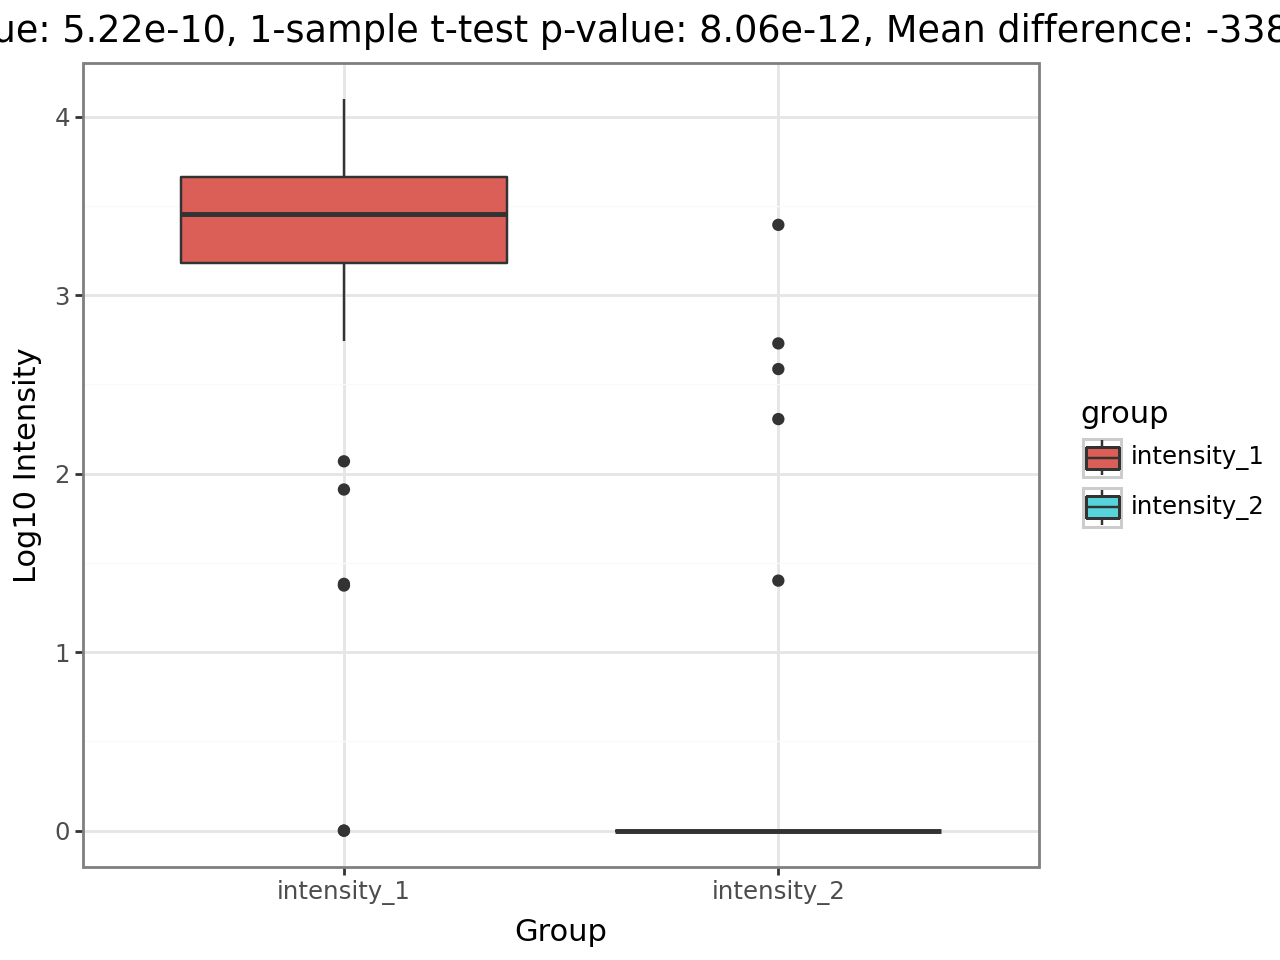

C:\Users\P42587\AppData\Roaming\Python\Python311\site-packages\IPython\lib\pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


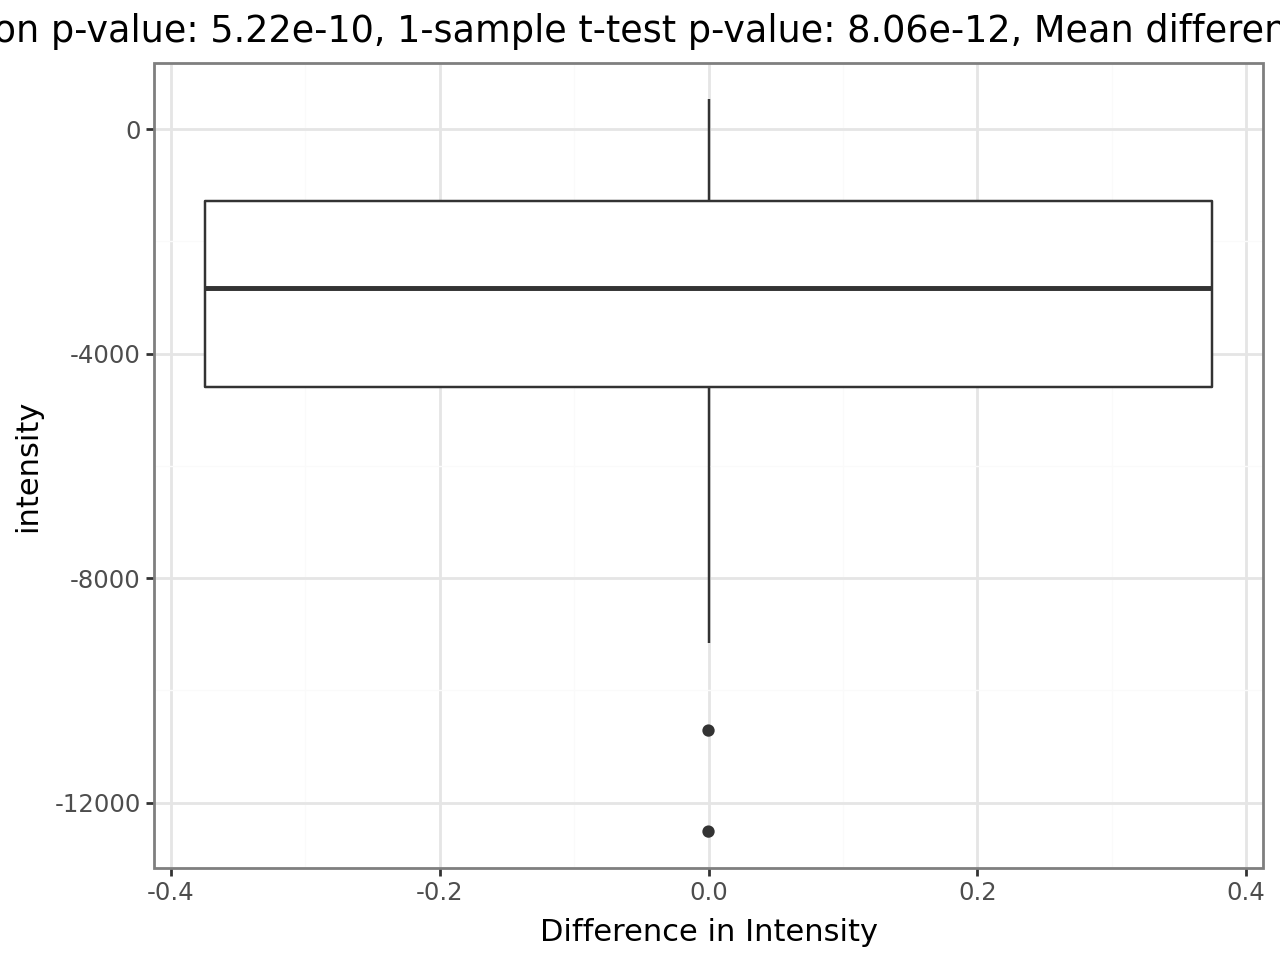

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [16]:
from fraggraph.frag_graph_report import barplot_intensity_compare_site_determining

barplot_intensity_compare_site_determining(
    FG_dual,
    FG_dual,
    mod1_position=pos_1,
    mod2_position=pos_2,
    FG1_peptidoform_index=0,
    FG2_peptidoform_index=1,
    ions_type="internal"
)

In [17]:
### DOESNT EXIST
"""
from source.frag_graph_report import *

# table = FG_dual.get_peak_table()
# # display table html
# from IPython.display import display, HTML
# display(HTML(table.to_html()))


#plot_mass_spectrum(FG_dual, color_map={"terminal": "black", "internal": "black","unassigned": "black", "both": "black"}, filename="jupyter_output/mass_spectrum_H3tail_ETD.svg")

plot_mass_spectrum_site_determining(FG_dual, exclusion_list=["internal","both","unassigned"], filename="jupyter_output/mass_spectrum_site_determining_H3tail_ETD.svg")

plot_mass_spectrum_site_determining(FG_dual, exclusion_list=["both","unassigned"], filename="jupyter_output/mass_spectrum_site_determining_H3tail_ETD_all.svg")
"""

'\nfrom source.frag_graph_report import *\n\n# table = FG_dual.get_peak_table()\n# # display table html\n# from IPython.display import display, HTML\n# display(HTML(table.to_html()))\n\n\n#plot_mass_spectrum(FG_dual, color_map={"terminal": "black", "internal": "black","unassigned": "black", "both": "black"}, filename="jupyter_output/mass_spectrum_H3tail_ETD.svg")\n\nplot_mass_spectrum_site_determining(FG_dual, exclusion_list=["internal","both","unassigned"], filename="jupyter_output/mass_spectrum_site_determining_H3tail_ETD.svg")\n\nplot_mass_spectrum_site_determining(FG_dual, exclusion_list=["both","unassigned"], filename="jupyter_output/mass_spectrum_site_determining_H3tail_ETD_all.svg")\n'

In [18]:
"""
FG_1 = FragGraph(fragmentation_parameters="ETD",terminals_only=True)
FG_1.generate_graph([PEPTIDOFORM],consensus_spectra["mz_mean"],consensus_spectra["its_mean"])
draw_graph(FG_1, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD_terminals_only.html"))

FG_2 = FragGraph(fragmentation_parameters="ETD",terminals_only=False, min_cosine_similarity=0)
FG_2.generate_graph([PEPTIDOFORM],consensus_spectra["mz_mean"],consensus_spectra["its_mean"])
draw_graph(FG_2, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD_all.html"))

FG_3 = FragGraph(fragmentation_parameters="ETD",terminals_only=False, min_cosine_similarity=0.7)
FG_3.generate_graph([PEPTIDOFORM],consensus_spectra["mz_mean"],consensus_spectra["its_mean"])
draw_graph(FG_3, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD_all_0.7.html"))
"""

'\nFG_1 = FragGraph(fragmentation_parameters="ETD",terminals_only=True)\nFG_1.generate_graph([PEPTIDOFORM],consensus_spectra["mz_mean"],consensus_spectra["its_mean"])\ndraw_graph(FG_1, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD_terminals_only.html"))\n\nFG_2 = FragGraph(fragmentation_parameters="ETD",terminals_only=False, min_cosine_similarity=0)\nFG_2.generate_graph([PEPTIDOFORM],consensus_spectra["mz_mean"],consensus_spectra["its_mean"])\ndraw_graph(FG_2, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD_all.html"))\n\nFG_3 = FragGraph(fragmentation_parameters="ETD",terminals_only=False, min_cosine_similarity=0.7)\nFG_3.generate_graph([PEPTIDOFORM],consensus_spectra["mz_mean"],consensus_spectra["its_mean"])\ndraw_graph(FG_3, output_filename=os.path.join("jupyter_output", f"graph_H3tail_ETD_all_0.7.html"))\n'